In [1]:
import numpy as np
import pandas as pd
import os
import glob
import json
from scipy.stats import ttest_ind
import pingouin as pg

In [2]:
# Define variables

# Raw dataset path
raw_dataset_path = "/home/gabridele/Desktop/psych_dataset/"

# Preprocessed dataset path
preproc_dataset =  "/home/gabridele/Desktop/preproc_psych/"

# Participants file path
participants_file = "/home/gabridele/Desktop/psych_dataset/participants.tsv"

# Name and location of output excel file
output_excel_file = f"fd_values_scap-fMRI.xlsx"

# Name and location of transposed excel file
transposed_excel_file = f"fd_values_scap-fMRI_transposed.xlsx"


1. Look at data just after preproc

In [3]:

participants_df = pd.read_csv(participants_file, sep='\t')

# Extract the subject IDs from the 'participant_id' column
subjects = participants_df['participant_id'].tolist()

# Define the tasks
TASKS = ['rest', 'bart', 'scap', 'stopsignal', 'taskswitch']

# Preallocate output array
output = np.zeros((len(subjects), len(TASKS)))

for i, s in enumerate(subjects):
    # Construct the file path for the subject's directory
    subject_dir = os.path.join('/home/gabridele/Desktop/preproc_psych', s, 'func')
    for j, task in enumerate(TASKS):
        # Check if any file exists in the subject's directory for each task
        file_path = os.path.join(subject_dir, '*')
        output[i, j] = len(glob.glob(file_path)) > 0


# Create DataFrame from the output array
df = pd.DataFrame(data=output, index=subjects, columns=TASKS)

# Generate a group variable based on subject IDs
df['group'] = np.where(df.index.str.startswith('sub-1'), 'CTRL',
                       np.where(df.index.str.startswith('sub-5'), 'SCZ',
                                np.where(df.index.str.startswith('sub-6'), 'BPLR',
                                         np.where(df.index.str.startswith('sub-7'), 'ADHD', 0))))

# Print information about the DataFrame
print('Data after preprocessing:', len(df))
display(df.head(5))
print(df['group'].value_counts())

df.to_csv('/home/gabridele/Desktop/preproc_psych/preproc_sub_list.csv', index=True)

#counting of subj is not realiable bc i copied raw folders into preproc folder. so there's subjs that didnt undergo preproc
# remove 5 ctrl and 2 adhd


Data after preprocessing: 272


,rest,bart,scap,stopsignal,taskswitch,group
sub-10159,1.0,1.0,1.0,1.0,1.0,CTRL
sub-10171,1.0,1.0,1.0,1.0,1.0,CTRL
sub-10189,1.0,1.0,1.0,1.0,1.0,CTRL
sub-10193,1.0,1.0,1.0,1.0,1.0,CTRL
sub-10206,1.0,1.0,1.0,1.0,1.0,CTRL


group
CTRL    130
SCZ      50
BPLR     49
ADHD     43
Name: count, dtype: int64


In [4]:
print(participants_df)

    participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159   CONTROL   30      F   1.0  NaN  1.0     NaN     NaN   
1        sub-10171   CONTROL   24      M   1.0  1.0  1.0     NaN     NaN   
2        sub-10189   CONTROL   49      M   1.0  NaN  1.0     NaN     NaN   
3        sub-10193   CONTROL   40      M   1.0  NaN  1.0     NaN     NaN   
4        sub-10206   CONTROL   21      M   1.0  NaN  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
267      sub-70079      ADHD   21      M   1.0  1.0  1.0     1.0     1.0   
268      sub-70080      ADHD   48      M   1.0  1.0  1.0     1.0     1.0   
269      sub-70081      ADHD   50      M   1.0  1.0  1.0     1.0     1.0   
270      sub-70083      ADHD   46      F   1.0  1.0  1.0     1.0     1.0   
271      sub-70086      ADHD   48      M   1.0  1.0  1.0     1.0     1.0   

     rest  scap  stopsignal  T1w  taskswitch  ScannerSerialNumber  \
0     1.0   1.0   

2. Excluding ghost and no dwi

In [5]:
participants_df = pd.read_csv(participants_file, delimiter='\t')

# Load missing_files_info.csv into missing_files_df
missing_files_df = pd.read_csv('/home/gabridele/Desktop/preproc_psych/missing_files_info.csv')

# Extract IDs of subjects marked as "ghost" from participants_df
ghost_ids = set(participants_df[participants_df['ghost_NoGhost'] == 'ghost']['participant_id'])

# Extract IDs from missing_files_df
missing_ids = set(missing_files_df['Subject'])

# Combine IDs from both sources into a single set
ids_to_drop = ghost_ids.union(missing_ids)

# Add name to subject IDs column and drop rows from df where subject_id is in ids_to_drop
df = df.rename_axis('participant_id').reset_index()
df = df[~df['participant_id'].isin(ids_to_drop)]

# Save the modified DataFrame to a new CSV file
df.to_csv('/home/gabridele/Desktop/preproc_psych/modified_dataframe.csv', index=False)

In [6]:
print(df)

    participant_id  rest  bart  scap  stopsignal  taskswitch group
0        sub-10159   1.0   1.0   1.0         1.0         1.0  CTRL
1        sub-10171   1.0   1.0   1.0         1.0         1.0  CTRL
2        sub-10189   1.0   1.0   1.0         1.0         1.0  CTRL
4        sub-10206   1.0   1.0   1.0         1.0         1.0  CTRL
5        sub-10217   1.0   1.0   1.0         1.0         1.0  CTRL
..             ...   ...   ...   ...         ...         ...   ...
267      sub-70079   1.0   1.0   1.0         1.0         1.0  ADHD
268      sub-70080   1.0   1.0   1.0         1.0         1.0  ADHD
269      sub-70081   1.0   1.0   1.0         1.0         1.0  ADHD
270      sub-70083   1.0   1.0   1.0         1.0         1.0  ADHD
271      sub-70086   1.0   1.0   1.0         1.0         1.0  ADHD

[211 rows x 7 columns]


Hearne excluded subjs that didnt have all of the task files. so computed an rsm mean across all the task files. maybe thats why im getting different results. not to mention the different preproc

3. Relative RMS

In [7]:
# relative RMS cutoff in mm (Satterthwaite et al. 2013)
RMSCutOff = 0.25
TASKS = ['scap']
# length cutoff (i.e., 20% of data)
RMS_length_CutOff = 0.20

# preallocate RMS array
RMS_data = np.zeros((len(df.index),len(TASKS)+2))
labels = []
for j, task in enumerate(TASKS):
    for s,subj in enumerate(df["participant_id"]):  
        # load the subjects confound data
        df_confounds = pd.read_csv(preproc_dataset + str(subj) + '/func/' + str(subj) + '_task-' + task + '_bold_confounds.tsv', sep='\t', header=0)

        # get 6 motions parameters
        motionParams = df_confounds[['X','Y','Z','RotX','RotY','RotZ']].values

        # calculate relative RMS
        displacement = np.zeros(np.shape(motionParams))
        for tr in range(1,len(motionParams)):
            for dim in range(0,3):
                displacement[tr,dim] = motionParams[tr,dim] - motionParams[tr-1,dim];

        relativeRMS = np.sqrt(displacement[:,0]**2 + displacement[:,1]**2+ displacement[:,2]**2)
        
        # save the data out
        RMS_data[s,j] = np.mean(relativeRMS)
        if (np.sum(relativeRMS > RMSCutOff) / float(len(relativeRMS))) > RMS_length_CutOff:
            RMS_data[s,-1] = 1
    labels.append('RMS-mean-'+task)
labels.append('RMS-avg')
RMS_data[:,-2] = np.mean(RMS_data[:,0:-3],axis=1)
labels.append('RMS-exclude')

# put the data in the df
RMS_df = pd.DataFrame(data=RMS_data,index=df.index,columns=labels)
df = pd.concat([df,RMS_df],axis=1)

# show excluded subjects
print('Dropped data due to RMS head motion')
print(df['group'].loc[df['RMS-exclude']==1].value_counts())

# drop the data and print
df = df[df['RMS-exclude']==0]
print('Data after RMS:',len(df))
print(df['group'].value_counts())

Dropped data due to RMS head motion
group
CTRL    5
BPLR    3
SCZ     2
ADHD    1
Name: count, dtype: int64
Data after RMS: 200
group
CTRL    101
BPLR     38
ADHD     34
SCZ      27
Name: count, dtype: int64


/home/gabridele/miniconda3/envs/neuroimg/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabridele/miniconda3/envs/neuroimg/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [8]:
print(df)

    participant_id  rest  bart  scap  stopsignal  taskswitch group  \
0        sub-10159   1.0   1.0   1.0         1.0         1.0  CTRL   
1        sub-10171   1.0   1.0   1.0         1.0         1.0  CTRL   
2        sub-10189   1.0   1.0   1.0         1.0         1.0  CTRL   
4        sub-10206   1.0   1.0   1.0         1.0         1.0  CTRL   
5        sub-10217   1.0   1.0   1.0         1.0         1.0  CTRL   
..             ...   ...   ...   ...         ...         ...   ...   
267      sub-70079   1.0   1.0   1.0         1.0         1.0  ADHD   
268      sub-70080   1.0   1.0   1.0         1.0         1.0  ADHD   
269      sub-70081   1.0   1.0   1.0         1.0         1.0  ADHD   
270      sub-70083   1.0   1.0   1.0         1.0         1.0  ADHD   
271      sub-70086   1.0   1.0   1.0         1.0         1.0  ADHD   

     RMS-mean-scap  RMS-avg  RMS-exclude  
0         0.088228      NaN          0.0  
1         0.067843      NaN          0.0  
2         0.070066      NaN   

4. Basic demos

In [9]:
def all_groups_ttest(df, labels=['age','sex','site']):
    output = ""
    groups = df['group'].unique()
    for label in labels:
        output += f"t-test, Var={label}\n"
        for i, group1 in enumerate(groups):
            for group2 in groups[i+1:]:
                x = df[df['group'] == group1][label].values
                y = df[df['group'] == group2][label].values
                t, p = ttest_ind(x, y, equal_var=False)
                output += f"\tComparing {group1} vs {group2}:\n"
                output += f"\t  t = {t}\n"
                output += f"\t  p = {p}\n"
                
    output += "\nMeans:\n"
    output += str(df.groupby(['group'])[labels].mean()) + "\n"
    output += "\nStd:\n"
    output += str(df.groupby(['group'])[labels].std()) + "\n"

    return output

def all_groups_stats(df, labels=['age','sex','site']):
    groups = df['group'].unique()
    for label in labels:
        for i, group1 in enumerate(groups):
            for group2 in groups[i+1:]:
                if label == 'sex' or label == 'site':
                    new_df = df.loc[(df['group'] == group1) | (df['group'] == group2)]
                    expected, observed, stats = pg.chi2_independence(data=new_df, x=label, y='group')
                    print(f"Chi-square test for {label} between {group1} and {group2}:")
                    print(f"\t Chi2 = {np.round(stats.chi2[0], 3)}")
                    print(f"\t p = {np.round(stats.pval[0], 4)}")
                else:
                    x = df[df['group'] == group1][label].values
                    y = df[df['group'] == group2][label].values
                    t, p = ttest_ind(x, y, equal_var=False)
                    print(f"t-test for {label} between {group1} and {group2}:")
                    print(f"\t t = {np.round(t, 3)}")
                    print(f"\t p = {p}")

In [35]:
df_participants = pd.read_csv(participants_file, sep='\t', header=0)

# Read demographics file
demographics_file = '/home/gabridele/Desktop/psych_dataset/phenotype/demographics.tsv'
df_demo = pd.read_csv(demographics_file, sep='\t', header=0)

# Read WAIS file
wais_file = '/home/gabridele/Desktop/psych_dataset/phenotype/wais.tsv'
df_wais = pd.read_csv(wais_file, sep='\t', header=0)

#preallocate
age = np.zeros((len(df.index)))
sex = age.copy()
site = age.copy()
edu_years = age.copy()
hand = age.copy()
wais_mr = age.copy() 
wais_lns = age.copy()
wais_voc = age.copy()

for subidx,subj in enumerate(df["participant_id"]):
    idx = df_participants.participant_id==subj
    
    #age
    age[subidx] = np.int64(df_participants.age[idx].values[0])
    
    #sex
    _sex = df_participants.gender[idx].values
    if _sex == 'F':
        sex[subidx] = 0

    elif _sex == 'M':
        sex[subidx] = 1

    #site
    data = []
    file = f'/home/gabridele/Desktop/psych_dataset/{subj}/func/{subj}_task-scap_bold.json'
    with open(file) as json_data:
        data.append(json.load(json_data))

    if data[0]['SoftwareVersions'] == 'syngo MR B15':
        site[subidx] = 1
    elif data[0]['SoftwareVersions'] == 'syngo MR B17':
        site[subidx] = 0

    # education (how many years of schooling complete?)
    edu_years[subidx] = np.int64(df_demo.school_yrs[idx].values[0])
    
    #
    #hand = 
    # wais
    wais_mr[subidx] = np.int64(df_wais.mr_totalraw[idx].values[0]) 
    wais_lns[subidx] = np.int64(df_wais.lns_totalraw[idx].values[0])
    wais_voc[subidx] = np.int64(df_wais.voc_totalraw[idx].values[0])
    
# put the data in the df
labels = ['age','sex','site','edu_years','wais_mr','wais_lns','wais_voc']
demo_data = np.vstack((age,sex,site,edu_years,wais_mr,wais_lns,wais_voc)).T
demo_df = pd.DataFrame(data=demo_data,index=df.index,columns=labels)
df = pd.concat([df,demo_df],axis=1)

# print average demos
print(df['group'].value_counts())
print(df.groupby('group')[['age', 'sex', 'site']].mean())
groups = ['CTRL', 'SCHZ', 'BPLR', 'ADHD']
df.to_excel('/home/gabridele/Desktop/preproc_psych/preproc_sub_list2.xlsx', index=True)

group
CTRL    101
BPLR     38
ADHD     34
SCZ      27
Name: count, dtype: int64
             age        age       sex       sex      site      site
group                                                              
ADHD   32.529412  32.529412  0.529412  0.529412  0.500000  0.500000
BPLR   34.500000  34.500000  0.500000  0.500000  0.473684  0.473684
CTRL   31.386139  31.386139  0.485149  0.485149  0.811881  0.811881
SCZ    36.185185  36.185185  0.740741  0.740741  0.370370  0.370370


In [31]:
idx = df_participants.participant_id==subj
print(len(idx))

272


In [36]:
all_groups_stats(df,labels=['age','sex','site'])

t-test for age between CTRL and SCZ:
	 t = [-2.455 -2.455]
	 p = [0.01854288 0.01854288]
t-test for age between CTRL and BPLR:
	 t = [-1.827 -1.827]
	 p = [0.07230341 0.07230341]
t-test for age between CTRL and ADHD:
	 t = [-0.578 -0.578]
	 p = [0.5657155 0.5657155]
t-test for age between SCZ and BPLR:
	 t = [0.739 0.739]
	 p = [0.46289268 0.46289268]
t-test for age between SCZ and ADHD:
	 t = [1.468 1.468]
	 p = [0.14748216 0.14748216]
t-test for age between BPLR and ADHD:
	 t = [0.857 0.857]
	 p = [0.39445999 0.39445999]


ValueError: Data must be 1-dimensional, got ndarray of shape (128, 2) instead

5. Manual HC cohort selection

In [ ]:
# not sure whether i should do it
# control for substantial differences in sex and age between groups, ideally we'd trim the HC cohort for a better sample

6. Behavioral outliers on the scap

In [37]:
def load_scan_behaviour(subj_list,task_list,group_index):
    '''
    Loads in-scanner task behaviour. Currently only coded up for the 'SCAP' task.
    For in-depth explanation of the tasks and the conditions modelled in the GLM
    see the postFmriprepPipelines.py script which does the GLM.
    
    returns: 
    - accuracy, 
    - reaction_time, 
    - accuracy_all, 
    - reaction_time_all, 
    - labels
    '''
    BIDS_DIR = "/home/gabridele/Desktop/psych_dataset/"
    accuracy_all = {}
    reaction_time_all = {}
    accuracy = {}
    reaction_time = {}
    labels = {}

    for task in task_list:
        if task=='scap':
            # 12 conditions - each cognitive load and each delay
            task_label = ['load1-delay1.5','load1-delay3','load1-delay4.5',
                     'load3-delay1.5','load3-delay3','load3-delay4.5',
                     'load5-delay1.5','load5-delay3','load5-delay4.5',
                     'load7-delay1.5','load7-delay3','load7-delay4.5']

            raw_acc = np.zeros((4,12,len(subj_list))) # trial x condition x subject
            raw_rt = raw_acc.copy()

            for i,subj in enumerate(subj_list):
                # get task information
                df_task = pd.read_csv(BIDS_DIR + str(subj) + '/func/' + str(subj) + '_task-' + task + '_events.tsv', sep='\t', header=0)

                for trial in range(1,13):
                    #accuracy
                    acc = df_task['ResponseAccuracy'].values[df_task['trial_type']==trial]=='CORRECT'
                    acc = acc.astype(int)
                    raw_acc[:,trial-1,i] = acc
                    #rt
                    rt = df_task['ReactionTime'].values[df_task['trial_type']==trial]
                    raw_rt[:,trial-1,i] = rt

        # put in a task list
        accuracy_all[task] = raw_acc
        reaction_time_all[task] = raw_rt
        labels[task] = task_label

        # put in a list with groups
        accuracy[task] = {}
        accuracy[task]['CTRL'] = raw_acc[:,:,group_index=='CTRL']
        accuracy[task]['SCZ'] = raw_acc[:,:,group_index=='SCZ']
        accuracy[task]['BPLR'] = raw_acc[:,:,group_index=='BPLR']
        accuracy[task]['ADHD'] = raw_acc[:,:,group_index=='ADHD']

        reaction_time[task] = {}
        reaction_time[task]['CTRL'] = raw_rt[:,:,group_index=='CTRL']
        reaction_time[task]['SCZ'] = raw_rt[:,:,group_index=='SCZ']
        reaction_time[task]['BPLR'] = raw_rt[:,:,group_index=='BPLR']
        reaction_time[task]['ADHD'] = raw_rt[:,:,group_index=='ADHD']
    return accuracy, reaction_time, accuracy_all, reaction_time_all, labels

Poor subjs: 65    sub-10680
79    sub-10788
Name: participant_id, dtype: object
Odd HC participant scored: [25.   31.25] %
Odd HC participant scored: [-5.09257658 -4.56431547] (zscore)


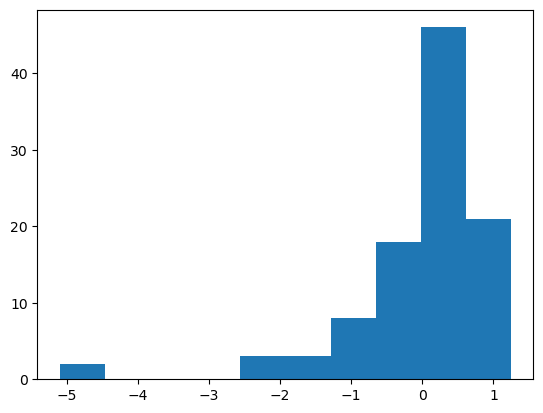

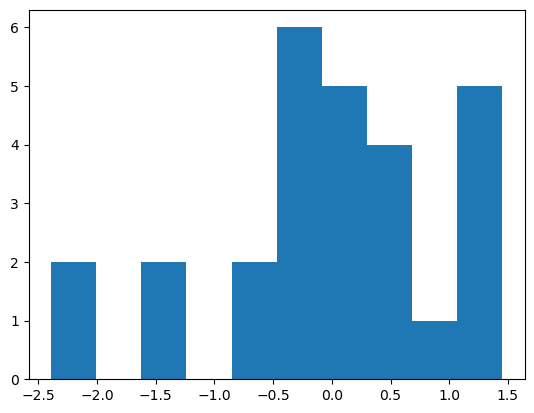

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
accuracy,reaction_time,_,_,task_labels = load_scan_behaviour(df["participant_id"],['scap'],df['group'].values)
hc_acc = np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0)
sz_acc = np.mean(np.mean(accuracy['scap']['SCZ'],axis=0),axis=0)

idx = zscore(hc_acc) < -4
bad_subjs = df["participant_id"][df['group']=='CTRL'][idx]
print('Poor subjs:',bad_subjs)
print('Odd HC participant scored:',hc_acc[idx]*100,'%')
print('Odd HC participant scored:',zscore(hc_acc)[idx],'(zscore)')

#plot the histograms
plt.hist(zscore(hc_acc))
plt.show()
plt.hist(zscore(sz_acc))
plt.show()

In [40]:
# Check if bad subjects exist in the index before dropping them
bad_subjs_to_drop = [subj for subj in bad_subjs if subj in df['participant_id'].values]

# Drop the bad subjects if they exist in the index
df = df[~df['participant_id'].isin(bad_subjs_to_drop)]

# print average demos
print(df['group'].value_counts())
print(df.groupby(['group'])[['age', 'sex', 'site']].mean())

all_groups_stats(df,labels=['age','sex','site'])

group
CTRL    99
BPLR    38
ADHD    34
SCZ     27
Name: count, dtype: int64
             age        age       sex       sex      site      site
group                                                              
ADHD   32.529412  32.529412  0.529412  0.529412  0.500000  0.500000
BPLR   34.500000  34.500000  0.500000  0.500000  0.473684  0.473684
CTRL   31.444444  31.444444  0.494949  0.494949  0.808081  0.808081
SCZ    36.185185  36.185185  0.740741  0.740741  0.370370  0.370370
t-test for age between CTRL and SCZ:
	 t = [-2.418 -2.418]
	 p = [0.02018944 0.02018944]
t-test for age between CTRL and BPLR:
	 t = [-1.786 -1.786]
	 p = [0.078665 0.078665]
t-test for age between CTRL and ADHD:
	 t = [-0.547 -0.547]
	 p = [0.58661023 0.58661023]
t-test for age between SCZ and BPLR:
	 t = [0.739 0.739]
	 p = [0.46289268 0.46289268]
t-test for age between SCZ and ADHD:
	 t = [1.468 1.468]
	 p = [0.14748216 0.14748216]
t-test for age between BPLR and ADHD:
	 t = [0.857 0.857]
	 p = [0.39445999 0

ValueError: Data must be 1-dimensional, got ndarray of shape (126, 2) instead

6. Save subj list

In [41]:
df.to_csv(preproc_dataset + 'subj_list.tsv', sep='\t', index=False)

# Get the values from the 'sub_id' column as a list
subj_list = df['participant_id'].tolist()
with open('subj_id_list.txt', 'w') as f:
    for item in subj_list:
        f.write("%s\n" % item)

7. Demographic table

In [42]:
print(df['group'].value_counts())
labels = ['age','sex','site','RMS-avg','edu_years','wais_mr','wais_lns','wais_voc']
print(df.groupby(['group'])[labels].mean())
ttest_results = all_groups_ttest(df, labels=labels)

txt_file_path = '/home/gabridele/Desktop/preproc_psych/ttest_results.txt'

# Save the output to a text file
with open(txt_file_path, 'w') as txt_file:
    txt_file.write(ttest_results)

group
CTRL    99
BPLR    38
ADHD    34
SCZ     27
Name: count, dtype: int64
             age        age       sex       sex      site      site  RMS-avg  \
group                                                                          
ADHD   32.529412  32.529412  0.529412  0.529412  0.500000  0.500000      NaN   
BPLR   34.500000  34.500000  0.500000  0.500000  0.473684  0.473684      NaN   
CTRL   31.444444  31.444444  0.494949  0.494949  0.808081  0.808081      NaN   
SCZ    36.185185  36.185185  0.740741  0.740741  0.370370  0.370370      NaN   

       edu_years  edu_years    wais_mr    wais_mr   wais_lns   wais_lns  \
group                                                                     
ADHD   14.617647  14.617647  20.323529  20.323529  19.941176  19.941176   
BPLR   14.789474  14.789474  19.368421  19.368421  19.657895  19.657895   
CTRL   15.141414  15.141414  20.646465  20.646465  21.111111  21.111111   
SCZ    12.666667  12.666667  14.037037  14.037037  17.851852  17.851